# Channel Model

This notebook is used to create Channel Model for mmWave base on extended Saleh-Valenzuela model, which allows us to accurately capture the mathematical structure present in mmWave channels.
Most content is base on the paper:

O. El Ayach, S. Rajagopal, S. Abu-Surra, Z. Pi, and R. Heath, “Spatially sparse precoding in millimeter wave MIMO systems,” IEEE Transactions on WirelessCommunications, vol. 13, no. 3, pp. 1499–1513, March 2014

and Matlab Sourcode from repository https://github.com/xyuam/Alternating-minimization-algorithms-for-hybrid-precoding-in-millimeter-wave-MIMO-systems

$$H = \sqrt{\frac{N_{t}N_{r}}{N_{cl}N_{ray}}}\sum_{i=1}^{N_{cl}}\sum_{l=1}^{N_{ray}}\alpha_{il}\mathbf{a_{r}}(\phi _{il}^{r},\theta _{il}^{r} )\mathbf{a_{t}}(\phi _{il}^{t},\theta _{il}^{t} )^{H}$$

Where $N_{cl}$ and $N_{ray}$ represent the number of clusters and the number of rays in each cluster, and $\alpha_{il}$ denotes the gain of the $l^{th}$ ray in the $i^{th}$ propagation cluster. We assume that $\alpha_{il}$ are i.i.d and follow the distribution $\mathcal{C}\mathcal{N}(0,\sigma _{\alpha ,i}^{2})$ and $\sum _{i=1}^{N_{cl}}\sigma _{\alpha ,i}^{2} = \hat{\gamma }$, which is the normalization factor to satisfy $\mathbf{E}\left [ \left \| \mathbf{H} \right \|_{F}^{2}\right ] = N_{t}N_{r}$. In addition $\mathbf{a_{r}}(\phi _{il}^{r},\theta _{il}^{r} )$ and $\mathbf{a_{t}}(\phi _{il}^{t},\theta _{il}^{t} )$ represent the receive and transmit array response vectors, where $\phi _{il}^{r}$($\phi _{il}^{t}$) and $\theta _{il}^{r}$($\theta _{il}^{t}$) stand for azimuth and elevation angles of arrival and departure, respectively. We use the uniform square planar array (USPA) with $\sqrt{N}$x$\sqrt{N}$ antenna elements.

In [1]:
# import necessary module 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
from array_response import *


### Array Response

This function is used to calculate the array response in uniform square planar array (USPA) with given azimuth, elevation angle and number of element
$$\mathbf{a}(\phi _{il},\theta _{il}) = \frac{1}{\sqrt{N}}[1,...,e^{j\frac{2\pi }{\lambda}d(psin\phi _{il}sin\theta _{il}+qcos\theta _{il})},...,e^{j\frac{2\pi }{\lambda}d((\sqrt{N}-1)sin\phi _{il}sin\theta _{il}+(\sqrt{N}-1)cos\theta _{il})}]^{T}$$

array_response is defined in array_response.py

### Parameters declaration

Declare parameters needed for channel realization

In [2]:
Ns = 3 # number of streams

Nc = 5 # number of cluster
Nray = 10 # number of rays in each cluster

Nt = 64 # number of transmit antennas
Nr = 16 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
sigma = 1 # according to the normalization condition of H

realization = 1000 # equivalent to number of taking sample
count = 0


### Example of Laplacian Distribution
Using Laplacian distributed for declaration of azimuth and elevation angles of arrival and departure (has been found to be a good fit for a variaty of propagation scenarios)

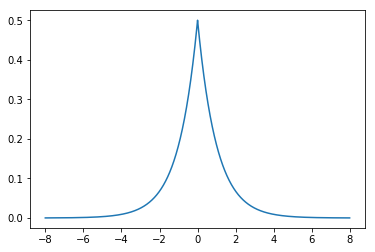

In [3]:
# plot the probability density function (PDF) of Laplacian Distribution
loc, scale = 0., 1.
s = np.random.laplace(loc, scale, 1000)
# count, bins, ignored = plt.hist(s, 30, normed=True)
x = np.arange(-8., 8., .01)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)
# example of create matrix of laplacian variables
y = np.random.laplace(loc, scale, (2,3))


### Channel Realization

Create Channel Matrix H and also the optimal Precoder and Combiner (Fopt and Wopt) for MIMO system

In [4]:
H = np.zeros((Nr,Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha = np.zeros((Nc*Nray,realization),dtype=complex)
Fopt = np.zeros((Nt,Ns,realization),dtype=complex)
Wopt = np.zeros((Nr,Ns,realization),dtype=complex)

AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Departure _ azimuth
        AoD_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Departure _ elevation
        AoA_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Arrival_ azimuth
        AoA_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Arrival_ elevation
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_azi_m, angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_ele_m, angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_azi_m, angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_ele_m, angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)
        alpha[j,reali] = np.random.normal(0, np.sqrt(sigma/2)) + 1j*np.random.normal(0, np.sqrt(sigma/2)) # related to power normalization
        H[:,:,reali] = H[:,:,reali] + alpha[j,reali]*Ar[:,[j],reali]@At[:,[j],reali].conj().T
    H[:,:,reali] = gamma* H[:,:,reali]
    if (np.linalg.matrix_rank(H[:,:,reali])>=Ns):
        count = count + 1
        U, s, V = np.linalg.svd(H[:,:,reali], full_matrices=True)
        V = V.conj().T
        Fopt[:,:,reali] = V[0:Nt,0:Ns]
        Wopt[:,:,reali] = U[0:Nr,0:Ns]

In [10]:
H.shape

(16, 64, 1000)

### Check normalized condition

In [5]:
channel_fro = np.zeros(realization)
for reali in range(realization):
    channel_fro[reali] = np.linalg.norm(H[:,:,reali],'fro')
print("Nt*Nr =", Nt*Nr , "   Frobenius norm =", np.mean(channel_fro**2))



Nt*Nr = 1024    Frobenius norm = 1030.331563333213


In [6]:
alpha.shape

(50, 1000)

**Store Variables to reuse**

In [7]:
var = {}
var['H']=H
var['Wopt']=Wopt
var['Fopt']=Fopt
var['Ns']=[[Ns]]
var['Nt']=[[Nt]]
var['Nr']=[[Nr]]
var['Nc']=[[Nc]]
var['Nray']=[[Nray]]
var['realization']=[[realization]]
var['At']=At
var['Ar']=Ar

io.savemat('temp',var)
